---

# Dependências

In [1]:
!sudo apt install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 10 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 1s (4,138 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debc

In [2]:
import cv2
import os
import pytesseract
import numpy as np
import PIL.Image
from pathlib import Path
from matplotlib import pyplot as plt

# Utils

In [3]:
def ocr(imagem):
    return pytesseract.image_to_string(imagem, config='--oem 1 --psm 7').split('\n')[0]

def convert_bgr_to_grayscale(bgr_img: np.ndarray) -> np.ndarray:
    """
    Converts an image from BGR to grayscale using the equation:
    C[y, x] = 0.114 * B[y, x] + 0.587 * G[y, x] + 0.299 * R[y, x]
    :param bgr_img: matrix (H, W, 3) which represents an image with height H, width W, and 3 color channels as BGR.
    :return: a new image (H, W) in grayscale in the 8 bits format.
    Uses truncation when converting floats to uint8 (for autograding).
    """
    gray_img = (bgr_img[:,:, 0]*0.114+bgr_img[:,:, 1]*0.587+bgr_img[:,:, 2]*0.299).astype(np.uint8)
    return gray_img

# def gain(img: np.ndarray, alpha: float, beta: float) -> np.ndarray:
#     """
#     This function implements an affine transform composed of additive and multiplicative gains following:
#     Ir[y, x] = alpha * I[y, x] + beta.
#     Moreover, the value is clipped to stay within the interval [0, 255].
#     :param img: matrix (H, W) or (H, W, C) which represents an image with height H, width W, and C color channels.
#     :param alpha: multiplicative gain.
#     :param beta: additive gain.
#     :return: the transformed image.
#     """
#     output_img = np.clip(img.astype(np.float64) * alpha + beta,0,255).astype(np.uint8)
#     return output_img

# def recover_dark_image(img: np.ndarray) -> np.ndarray:
#     """
#     Apply a gain transform to recover a dark image of a container plane.
#     :param img: matrix (H, W) or (H, W, C) which represents an image of height H, width W, and C color channels.
#     :return: a recovered image, where it is possible to visualize the characters of the plate.
#     """
#     return gain(img,10.0,180)

def padding(image: np.ndarray, border_color: tuple, padding: tuple) -> np.ndarray:
    """
    Add padding to an image.
    :param image: matrix (H, W, C) which represents an image of height H, width W, and C color channels.
    :param border_color: tuple (C1, C2, C3, ...) which represents a color that can be applied to a border.
    :param padding: tuple (left, right, top, bottom) which represents the amount of pixels to be added
                    to each border.
    :return: the image after padding.
    """
    h0, w0, c = image.shape
    left, right, top, bottom = padding
    padded_image = np.zeros((h0 + top + bottom, w0 + left + right, c), dtype=np.uint8)

    padded_image[top:top + h0, left:left + w0, :] = image

    padded_image[:top, :, :] = border_color
    padded_image[top + h0:, :, :] = border_color
    padded_image[:, :left, :] = border_color
    padded_image[:, left + w0:, :] = border_color

    return padded_image

def plate_padding(image):
  """
  Adds padding to a plate image so the OCR method can correctly identify the characters.
  :param image: matrix (H, W, 3) which represents an image of height H, width W, and 3 color channels.
  :return: an image where characters close to the borders are recognizable by the OCR method.
  """
  return padding(image, (255, ), (4, 4, 4, 4))

# Dataset

In [4]:
!rm -rf placas

In [5]:
! [ ! -d "/content/placas" ] && gdown -O /content/placas.zip 1JC0d28kH--8TYTIfMhbbHvbI5NPWzsdr &&  unzip /content/placas.zip -d /content && rm /content/placas.zip

imgs_path = Path("/content/placas")

Downloading...
From: https://drive.google.com/uc?id=1JC0d28kH--8TYTIfMhbbHvbI5NPWzsdr
To: /content/placas.zip
100% 637k/637k [00:00<00:00, 128MB/s]
Archive:  /content/placas.zip
   creating: /content/placas/
  inflating: /content/placas/placa.png  
  inflating: /content/placas/placa_ruido.png  
  inflating: /content/placas/picture.png  
  inflating: /content/placas/placa_ruido_base.png  
  inflating: /content/placas/placa_original.jpg  
  inflating: /content/placas/placa_cortada.png  
  inflating: /content/placas/Cod (17).jpg  
  inflating: /content/placas/Cod (0).jpg  
  inflating: /content/placas/placa_cortada_.png  
  inflating: /content/placas/Cod (14).jpg  
  inflating: /content/placas/Cod (8).jpg  
  inflating: /content/placas/placa_escura_.png  
  inflating: /content/placas/Cod (1).jpg  
  inflating: /content/placas/placa_escura.png  
  inflating: /content/placas/Cod (11).jpg  
  inflating: /content/placas/placa_.png  
  inflating: /content/placas/placa_erodida.png  
  inflating

MASH! 999657 Gf


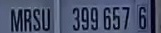

In [6]:
plate = cv2.cvtColor(cv2.imread(str(imgs_path/'placa_original.jpg')), cv2.COLOR_BGR2RGB)
print(ocr(plate))
PIL.Image.fromarray(plate)

# Manipulações Vetoriais

## Grayscale

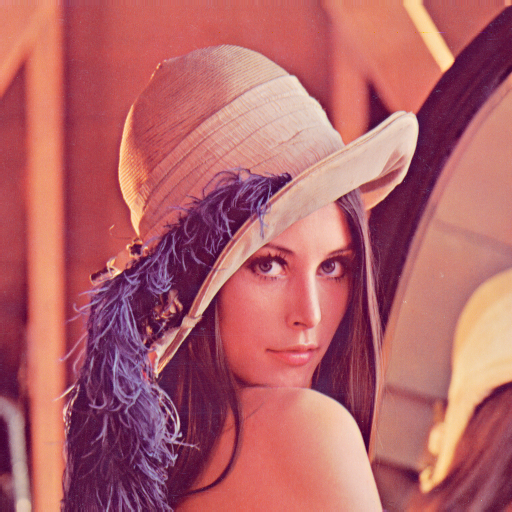

In [7]:
img = cv2.imread(str(imgs_path/'picture.png'))
PIL.Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) # Pillow expects a RGB image

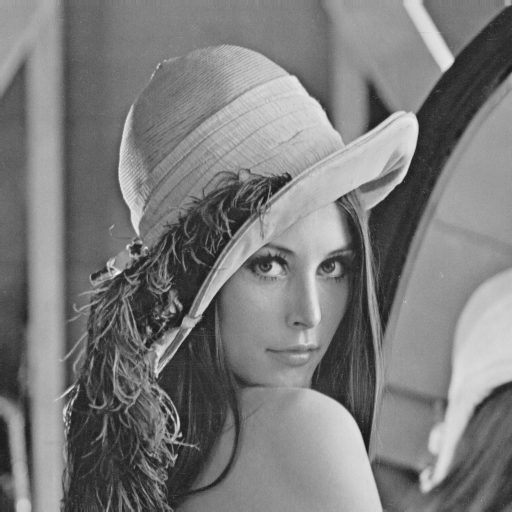

In [8]:
gray_img = convert_bgr_to_grayscale(img)
PIL.Image.fromarray(gray_img)

## Padding

In [9]:
cropped_plate = cv2.imread(str(imgs_path/'placa_cortada.png'))

print(ocr(cropped_plate))
PIL.Image.fromarray(cv2.cvtColor(cropped_plate, cv2.COLOR_BGR2RGB))

HI BL 3sH5 6/4 st


In [10]:
padded_plate = plate_padding(cropped_plate)

print(ocr(padded_plate))
PIL.Image.fromarray(padded_plate)

HLBU 305874 1


## Correlação Cruzada e Convolução

Vamos implementar correlação cruzada aqui. A diferença em relação a Concolução não é muito significativa, porque podemos realizar convolução usando correlação cruzada simplesmente invertendo o núcleo horizontal e verticalmente.

In [11]:
def cross_correlation(image: np.ndarray, kernel: np.ndarray) -> np.ndarray:
    """
    Executes cross correlation of an image using a filter (kernel or mask).
    :param image: matrix (H, W) which represents an image of height H and width W.
    :param kernel: matrix (Hf, Wf) which represents a filter (kernel or mask) of height Hf and width Wf.
    :return: the result of the cross correlation between the image and the filter.
    """
    h0, w0 = image.shape
    hf, wf = kernel.shape
    output = np.zeros((h0 - hf + 1, w0 - wf + 1), dtype=np.float64)
    for i in range(h0 - hf + 1):
        for j in range(w0 - wf + 1):
            output[i, j] = np.sum(kernel*image[i:i + hf, j:j + wf])
    return output


In [12]:
assert np.all(cross_correlation(
    np.array([[1, 1, 1, 0, 0],
              [0, 1, 1, 1, 0],
              [0, 0, 1, 1, 1],
              [0, 0, 1, 1, 0],
              [0, 1, 1, 0, 0]]),
    np.array([[1, 0, 1],
              [0, 1, 0],
              [1, 0, 1]])) == np.array([[4, 3, 4],
                                        [2, 4, 3],
                                        [2, 3, 4]]))

Uma correlação cruzada com um determinado filtro (kernel) pode implementar uma operação matemática conhecida. Por exemplo, o filtro de Sobel implementa uma derivada parcial da imagem através da diferença finita. A correlação cruzada da imagem com o filtro de Sobel produz uma imagem que enfatiza os contornos verticais na imagem original. O filtro de Sobel para calcular a derivada parcial x da imagem é dado por:

$\mathbf {S} _{x}={\begin{bmatrix}+1&0&-1\\+2&0&-2\\+1&0&-1\end{bmatrix}}$



[]

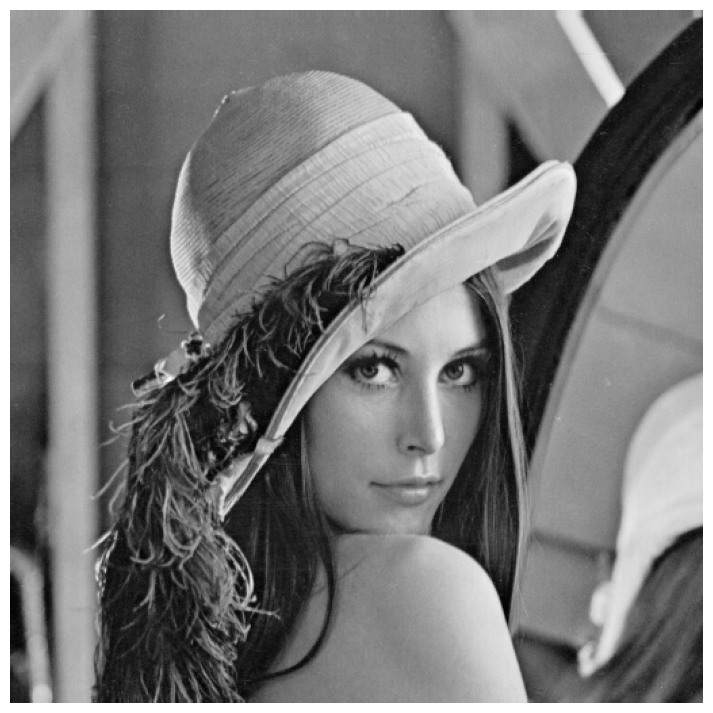

In [13]:
plt.figure(figsize=(9,9))
plt.axis(False)
plt.imshow(gray_img, cmap='gray')
plt.plot()

[]

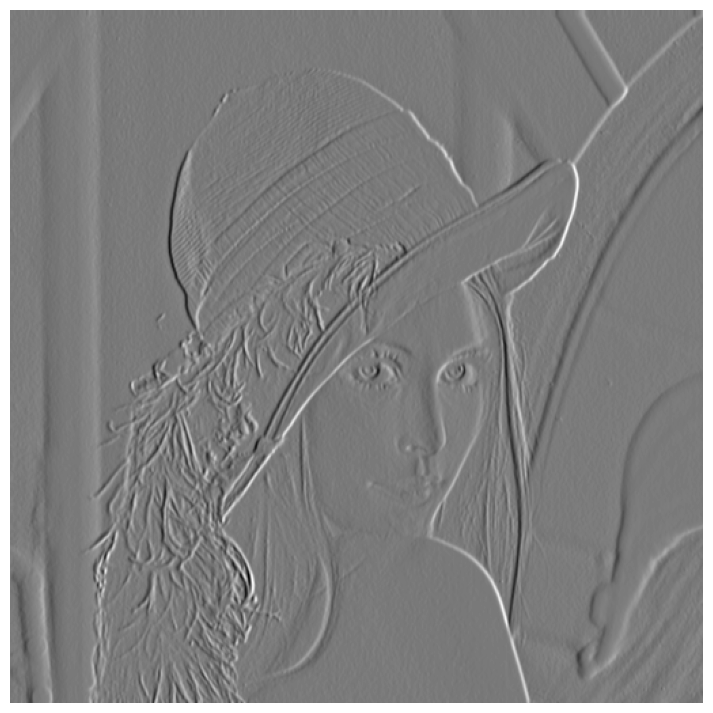

In [14]:
sobel_x = np.array([[1, 0, -1],
                    [2, 0, -2],
                    [1, 0, -1]])
gray_img_dx = cross_correlation(gray_img, sobel_x)
plt.figure(figsize=(9,9))
plt.axis(False)
plt.imshow(gray_img_dx, cmap='gray')
plt.plot()

## Convolução

A implementação abaixo corresponde à operação matemática equivalente à convolução, pois o núcleo está invertido.

Operação de correlação cruzada:

$G[i, j] = \sum^k_{u=-k} \sum^k_{v=-k} H[u, v] I[i - u, j - v]$

In [15]:
def convolution(image: np.ndarray, kernel: np.ndarray) -> np.ndarray:
    """
    Executes convolution of an image using a filter (kernel or mask).
    :param image: matrix (H, W) which represents an image of height H and width W.
    :param kernel: matrix (Hf, Wf) which represents a filter (kernel or mask) of height Hf and width Wf.
    :return: the result of the convolution between the image and the filter.
    """
    h0, w0 = image.shape
    hf, wf = kernel.shape
    output = np.zeros((h0 - hf + 1, w0 - wf + 1), dtype=np.float64)
    for i in range(h0 - hf + 1):
        for j in range(w0 - wf + 1):
            output[i, j] = np.sum(np.flip(kernel) * image[i:i + hf, j:j + wf])
    return output

[]

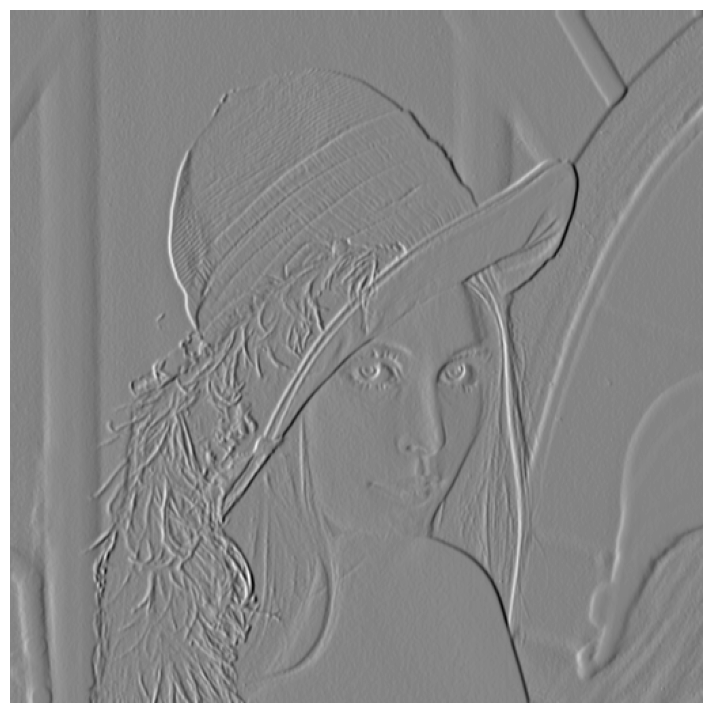

In [16]:
sobel_x = np.array([[1, 0, -1],
                    [2, 0, -2],
                    [1, 0, -1]])
gray_img_cx = convolution(gray_img, sobel_x)
plt.figure(figsize=(9,9))
plt.axis(False)
plt.imshow(gray_img_cx, cmap='gray')
plt.plot()

## Filtro Gaussiano

O filtro gaussiano é frequentemente usado para desfocar imagens ou atenuar ruídos. O kernel do filtro gaussiano é uma aproximação discreta da função gaussiana 2D:

$H(x, j) = \frac{1}{2 \pi \sigma^2} \exp \left( -\frac{(x - x_0)^2 + (y - y_0)^2}{2 \sigma^2} \right)$.

A aproximação discreta é calculada como:

$H[u, v] = \alpha  \exp \left( \frac{-(u-u_0)^2 + (v-v_0)^2}{2 \sigma^2} \right)$,

onde α é uma constante de normalização para que os valores do kernel somem 1 e σ é um parâmetro de design.

Este é o melhor filtro clássico para atenuar ruído gaussiano. Também pode ser interpretado como um filtro passa-baixo que atenua altas frequências. Usando uma transformada de Fourier, podemos verificar que este filtro atenua altas frequências.


In [17]:
def build_gaussian_kernel(k, sigma):
    """
    Builds a Gaussian kernel of size k and standard deviation sigma.
    :param k: kernel size.
    :param sigma: standard deviation.
    Retorna o kernel gaussiano normalizado, matriz float de tamanho (k, k) tipo float64
    """
    kernel = np.zeros((k, k), dtype=np.float64)

    u0 = v0 = (k - 1) / 2

    for i in range(k):
        for j in range(k):
            kernel[i, j] = np.exp(-((i-u0)**2 + (j-v0)**2) / (2 * sigma**2))

    alpha = 1 / np.sum(kernel)

    return alpha * kernel


[]

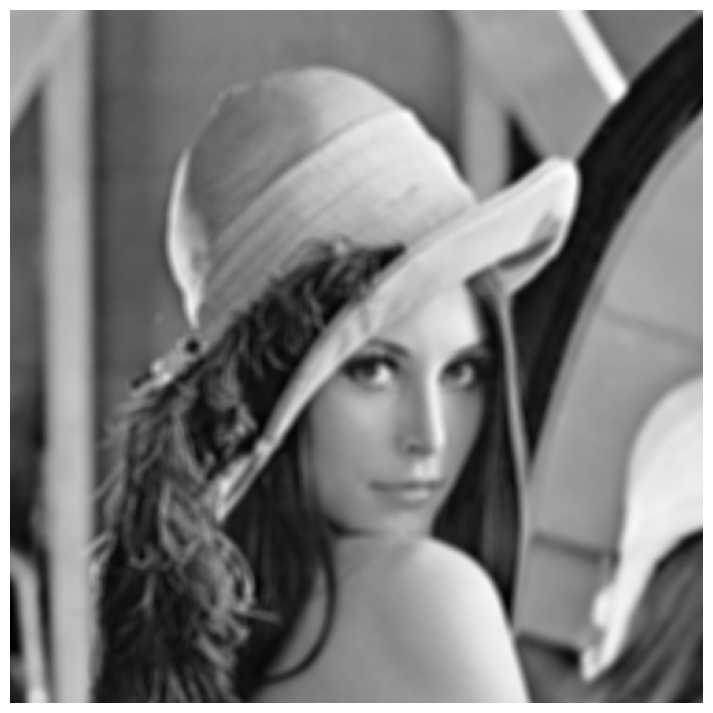

In [18]:
blurred_img = cross_correlation(gray_img, build_gaussian_kernel(7, 5))
plt.figure(figsize=(9,9))
plt.axis(False)
plt.imshow(blurred_img, cmap='gray')
plt.plot()

Sharpen Kernel:
[[-0.12 -0.12 -0.12 -0.12 -0.12]
 [-0.12 -0.12 -0.12 -0.12 -0.12]
 [-0.12 -0.12  3.88 -0.12 -0.12]
 [-0.12 -0.12 -0.12 -0.12 -0.12]
 [-0.12 -0.12 -0.12 -0.12 -0.12]]


[]

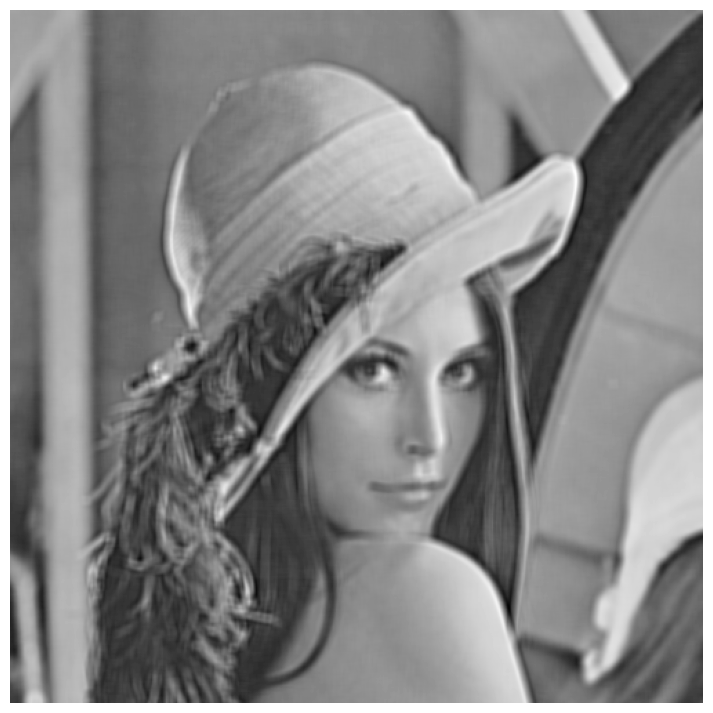

In [19]:
identity_kernel = np.zeros((5, 5))
identity_kernel[2, 2] = 1
sharpen_kernel = 4 * identity_kernel - 3 * np.ones((5, 5)) / (5 * 5)
print('Sharpen Kernel:')
print(sharpen_kernel)
sharpened_img = cross_correlation(blurred_img, sharpen_kernel)
plt.figure(figsize=(9,9))
plt.axis(False)
plt.imshow(sharpened_img, cmap='gray')
plt.plot()

## Noise

O ruído gaussiano está relacionado especialmente à amostragem de fótons incidentes nos sensores de imagem e aos fótons espúrios provenientes da radiação corporal negra.

O filtro clássico que melhor atenua o ruído gaussiano é o filtro gaussiano.

Para cada pixel, uma variável aleatória seguindo uma distribuição gaussiana é adicionada ao valor do pixel:

$I'[i,j] = I[i,j] + \eta[i,j]$,

Onde $\eta[i,j] \sim N(0,\sigma^2)$.


In [20]:
def filter_noise_plate(image: np.ndarray) -> np.ndarray:
    """
    Applies a Gaussian filter in a plate's image so the OCR is able to identify the characters. Uses the cross correlation
    function with a Gaussian filter.
    :param image: matrix (H, W) which represents an image with height H and width W.
    :return: filtered image so the characters are  identifiable by the OCR.
    """
    kernel = build_gaussian_kernel(3, 2)

    filtered_img = cross_correlation(image, kernel)
    return filtered_img.astype(np.uint8)

In [21]:
noisy_plate = convert_bgr_to_grayscale(cv2.imread(str(imgs_path/'placa_ruido.png')))
filtered_plate = filter_noise_plate(noisy_plate)
assert ocr(filtered_plate) == 'MEDU 297781 3'


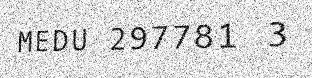

In [22]:
print(ocr(noisy_plate))
PIL.Image.fromarray(noisy_plate)

MEDU 297781 3


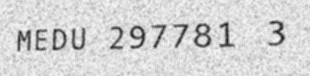

In [23]:
print(ocr(filtered_plate))
PIL.Image.fromarray(filtered_plate)

## Operações Morfológicas

As operações morfológicas são semelhantes à correlação cruzada com um kernel, pois deslizamos uma janela pela imagem. No entanto, as operações são não lineares. Por exemplo, as operações morfológicas de dilatação e erosão escolhem o máximo e o mínimo da janela, respectivamente. Essas operações são implementadas no OpenCV por cv2.dilate e cv2.erode, respectivamente.

![Dilatação](https://penny-xu.github.io/dialate-d6ec2fc1995eeeb95b917db2c6e1cea0.gif)

As operações morfológicas são definidas para imagens binárias. No entanto, também podemos generalizá-las para tons de cinza (elemento máximo/mínimo de uma janela).

Além disso, para binarizar a imagem de Lena abaixo, usamos um limiar de 120.

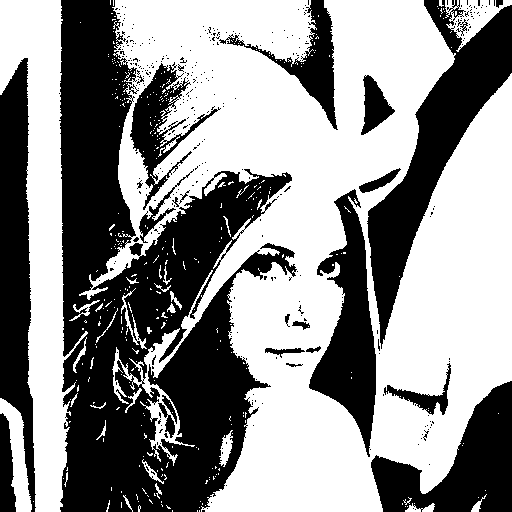

In [24]:
binary_img = 255 * (gray_img > 120).astype(np.uint8)
PIL.Image.fromarray(binary_img)

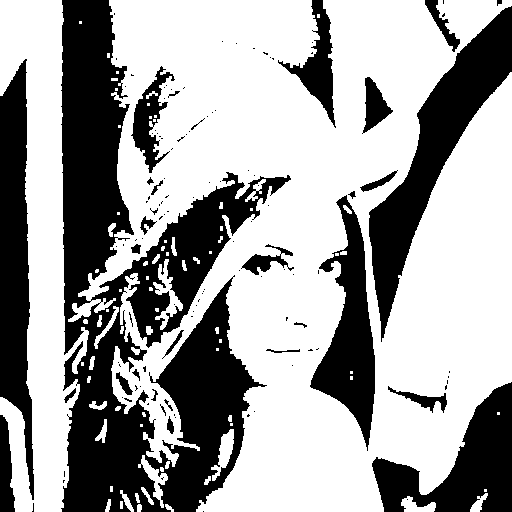

In [25]:
structuring_element = np.ones((3, 3))
dillated_img = cv2.dilate(binary_img, structuring_element)
PIL.Image.fromarray(dillated_img)

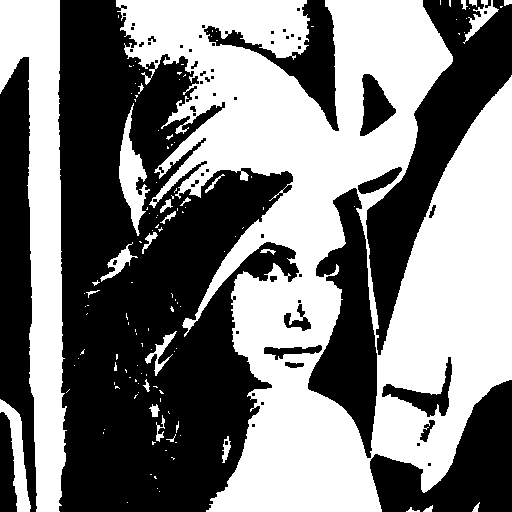

In [26]:
structuring_element = np.ones((3, 3))
eroded_img = cv2.erode(binary_img, structuring_element)
PIL.Image.fromarray(eroded_img)

APLU 345314 4


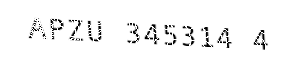

In [27]:
faint_plate = convert_bgr_to_grayscale(cv2.imread(str(imgs_path/'placa_erodida.png')))
print(ocr(faint_plate))
PIL.Image.fromarray(faint_plate)

In [28]:
def morphological_operation_plate(image: np.ndarray) -> np.ndarray:
    """
    Executes a morphological operation to recover the plate.
    :param image: matrix (H, W) which represents an image of height H and width W.
    :return: image after morphological operation that allows the identification of the characters through OCR.
    """
    structuring_element = np.ones((3, 3))

    output = cross_correlation(image, structuring_element)
    return output.astype(np.uint8)

APZU 345314 4


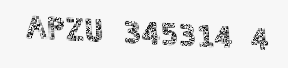

In [29]:
faint_plate = convert_bgr_to_grayscale(cv2.imread(str(imgs_path/'placa_erodida.png')))
recovered_plate = morphological_operation_plate(faint_plate)
print(ocr(recovered_plate))
PIL.Image.fromarray(recovered_plate)